
# Week 4 — Predictive Modelling (ORD TSA Throughput)

**Goal:** Forecast daily passenger throughput at Chicago O'Hare (ORD) and classify surge vs. normal days using simple, interpretable models aligned with Week 3 EDA.



## 1. Cleaning & Preprocessing

We load the hourly TSA throughput file, aggregate lanes into a single `pax` count, then roll up to **daily totals**. We also engineer simple time-derived features and lag/rolling features suitable for forecasting.


In [3]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

Saving TsaThroughput.ORD.csv to TsaThroughput.ORD (1).csv


In [4]:

# Chose source file
    file_name = next(iter(uploaded))
except Exception:
    file_name = 'TsaThroughput.ORD.csv'

# Loaded raw CSV
raw = pd.read_csv(file_name)

# Built total hourly pax from all ORD-* lane columns (with a safe fallback)
ord_cols = [c for c in raw.columns if isinstance(c, str) and c.startswith('ORD ')]
if not ord_cols:
    ignore = {'Date','Hour','date','hour'}
    ord_cols = [c for c in raw.columns if c not in ignore and pd.api.types.is_numeric_dtype(raw[c])]

df = raw.copy()
df['pax'] = df[ord_cols].sum(axis=1)

# Parsed date
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
else:
    df['date'] = pd.to_datetime(df['Date'], errors='coerce')

# Parsed hour (handled numeric or time strings like HH:MM or HH:MM:SS)
if 'hour' in df.columns and pd.api.types.is_numeric_dtype(df['hour']):
    df['hour'] = df['hour'].astype(int)
elif 'Hour' in df.columns:
    if pd.api.types.is_numeric_dtype(df['Hour']):
        df['hour'] = df['Hour'].astype(int)
    else:
        parsed = pd.to_datetime(df['Hour'], errors='coerce')
        if parsed.notna().any():
            df['hour'] = parsed.dt.hour
        else:
            df['hour'] = pd.to_numeric(df['Hour'].astype(str).str.extract(r'(\d{1,2})')[0], errors='coerce').fillna(0).astype(int)
else:
    df['hour'] = 0

# Aggregated to daily series and filled small gaps
daily = df.groupby('date', as_index=False)['pax'].sum().sort_values('date')
daily = daily.set_index('date').asfreq('D')
daily['pax'] = daily['pax'].interpolate(limit_direction='both')

# Engineered calendar + simple lag/rolling features
daily['dow'] = daily.index.dayofweek        # 0=Mon
daily['dom'] = daily.index.day
daily['month'] = daily.index.month
daily['is_weekend'] = (daily['dow'] >= 5).astype(int)

for L in [1, 7, 14]:
    daily[f'lag_{L}'] = daily['pax'].shift(L)

for W in [7, 14]:
    daily[f'rollmean_{W}'] = daily['pax'].shift(1).rolling(W).mean()

print("Built daily features:", daily.shape)
daily.head()


Built daily features: (2345, 10)


/tmp/ipython-input-307991681.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df['Hour'], errors='coerce')


,pax,dow,dom,month,is_weekend,lag_1,lag_7,lag_14,rollmean_7,rollmean_14
date,,,,,,,,,,
2018-12-30,78210.0,6,30,12,1,NaN,NaN,NaN,NaN,NaN
2018-12-31,64206.0,0,31,12,0,78210.0,NaN,NaN,NaN,NaN
2019-01-01,72784.0,1,1,1,0,64206.0,NaN,NaN,NaN,NaN
2019-01-02,80399.0,2,2,1,0,72784.0,NaN,NaN,NaN,NaN
2019-01-03,71986.0,3,3,1,0,80399.0,NaN,NaN,NaN,NaN



## 2. Generating Sample Continuous Data to Use for Regression

Our **continuous target** is the **daily total `pax`**. We form a supervised learning table (`X`, `y`) using the engineered features above, then split chronologically into **train/validation/test**.


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Created categorical names (for simple one-hot features)
daily = daily.copy()
daily['dow_name']   = daily.index.day_name()
daily['month_name'] = daily.index.month_name()

# Defined candidate feature lists (selected only those that existed)
candidate_num = ['dow','dom','month','is_weekend','lag_1','lag_7','lag_14','rollmean_7','rollmean_14']
candidate_cat = ['dow_name','month_name']

num_features = [c for c in candidate_num if c in daily.columns]
cat_features = [c for c in candidate_cat if c in daily.columns]

# Set a continuous target (used log1p to tame skew; raw target y_raw also kept)
y_raw = daily['pax']
y_reg = np.log1p(daily['pax'])

# Built base feature frame
X_base = daily[num_features + cat_features]

# Built preprocessing: scaled numeric, one-hot encoded categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop",
    sparse_threshold=0.0,
)

# Transformed the full feature matrix (kept it simple like the example)
X_processed = preprocessor.fit_transform(X_base)

# Built readable column names
num_names = num_features
cat_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)) if cat_features else []
new_feature_names = num_names + cat_names

X_df = pd.DataFrame(X_processed, index=daily.index, columns=new_feature_names)

print("Preview of processed features:")
display(X_df.head())

# Split features and target for regression (70/30, chronological)
# (Used shuffle=False since this was a time series.)
n = len(X_df)
split = int(n * 0.7)

X_train = X_df.iloc[:split]
X_test  = X_df.iloc[split:]
y_reg_train = y_reg.iloc[:split]
y_reg_test  = y_reg.iloc[split:]

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_reg_train.shape, "y_test:", y_reg_test.shape)

Preview of processed features:


,dow,dom,month,is_weekend,lag_1,lag_7,lag_14,rollmean_7,rollmean_14,dow_name_Friday,...,month_name_December,month_name_February,month_name_January,month_name_July,month_name_June,month_name_March,month_name_May,month_name_November,month_name_October,month_name_September
date,,,,,,,,,,,,,,,,,,,,,
2018-12-30,0.75,0.933333,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,-0.75,1.000000,1.000000,0.0,0.283459,NaN,NaN,NaN,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,-0.50,-1.000000,-0.833333,0.0,-0.239850,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-02,-0.25,-0.933333,-0.833333,0.0,0.080697,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.00,-0.866667,-0.833333,0.0,0.365258,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shapes — X_train: (1641, 28) X_test: (704, 28) y_train: (1641,) y_test: (704,)


In [ ]:

# Drop rows with NaN due to lags
data = daily.dropna().copy()

# Target and features
y = data['pax']
X = data.drop(columns=['pax'])

# Chronological split: last 30 days = test, prior 60 = validation
test_days = 30
val_days = 60

y_train = y.iloc[:-(val_days + test_days)]
y_val   = y.iloc[-(val_days + test_days):-test_days]
y_test  = y.iloc[-test_days:]

X_train = X.loc[y_train.index]
X_val   = X.loc[y_val.index]
X_test  = X.loc[y_test.index]

print("Train:", y_train.index.min(), "→", y_train.index.max(), len(y_train))
print("Val  :", y_val.index.min(),   "→", y_val.index.max(),   len(y_val))
print("Test :", y_test.index.min(),  "→", y_test.index.max(),  len(y_test))


Train: 2019-01-13 00:00:00 → 2025-03-02 00:00:00 2241
Val  : 2025-03-03 00:00:00 → 2025-05-01 00:00:00 60
Test : 2025-05-02 00:00:00 → 2025-05-31 00:00:00 30



## 3. Regression Models

We keep models **simple and interpretable**:

- **Baseline (Naïve t−1):** uses yesterday's value.  
- **Linear Regression:** captures linear relationships in lags/rolls/calendar.  
- **Decision Tree Regressor:** simple non-linear splits, easy to explain.

We evaluate with **MAE**, **RMSE**, and **MAPE**.


Linear Regression: {'R2_log': 0.008969520381871043, 'MSE_log': 0.025893954342050465, 'MAE_log': 0.12664058095759195, 'RMSE_orig': np.float64(14691.260940523622), 'MAE_orig': 11120.682206792766, 'MAPE%_orig': np.float64(13.761422975114101)}
Decision Tree: {'R2_log': 0.5162510645976023, 'MSE_log': 0.012639543489269756, 'MAE_log': 0.08779598149958866, 'RMSE_orig': np.float64(8691.266645299165), 'MAE_orig': 6858.543306237314, 'MAPE%_orig': np.float64(8.80828688694118)}
Random Forest: {'R2_log': 0.7683187770106301, 'MSE_log': 0.006053439458601506, 'MAE_log': 0.05804780531373535, 'RMSE_orig': np.float64(5968.400085718331), 'MAE_orig': 4514.283375406263, 'MAPE%_orig': np.float64(5.825325503327236)}

Selected (by MAE_orig): RandomForestRegressor(n=200)


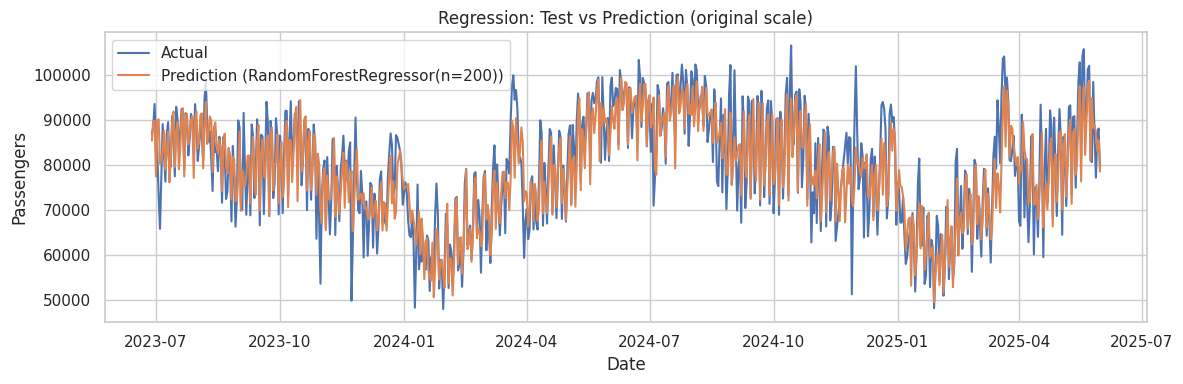


Top Random Forest importances:


,0
rollmean_7,0.443186
lag_1,0.408821
lag_7,0.123826
lag_14,0.006776
dom,0.003049
rollmean_14,0.002693
dow,0.002121
month,0.001784
dow_name_Tuesday,0.001288
dow_name_Saturday,0.001224


In [9]:
# ================================
# 3) Regression models (simple, past tense)
# ================================
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Guarded against any residual NaNs and aligned indices
X_tr = X_train.copy()
y_tr = y_reg_train.copy()
mask_tr = X_tr.notna().all(axis=1) & y_tr.notna()
X_tr = X_tr.loc[mask_tr]
y_tr = y_tr.loc[mask_tr]

X_te = X_test.copy()
y_te = y_reg_test.copy()
mask_te = X_te.notna().all(axis=1) & y_te.notna()
X_te = X_te.loc[mask_te]
y_te = y_te.loc[mask_te]

def eval_on_log_and_original(y_true_log, y_pred_log):
    # Computed log-space metrics (matched target definition)
    r2  = r2_score(y_true_log, y_pred_log)
    mse = mean_squared_error(y_true_log, y_pred_log)
    mae = mean_absolute_error(y_true_log, y_pred_log)
    # Back-transformed to original passengers for interpretability
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse_o = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_o  = mean_absolute_error(y_true, y_pred)
    mape_o = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    return {
        "R2_log": r2, "MSE_log": mse, "MAE_log": mae,
        "RMSE_orig": rmse_o, "MAE_orig": mae_o, "MAPE%_orig": mape_o
    }

results = {}

# --- Linear Regression (interpretable) ---
lin_reg = LinearRegression()
lin_reg.fit(X_tr, y_tr)
y_pred_lin = lin_reg.predict(X_te)
results["LinearRegression"] = eval_on_log_and_original(y_te, y_pred_lin)

print("Linear Regression:", results["LinearRegression"])

# --- Decision Tree Regressor (simple non-linear) ---
dt_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_reg.fit(X_tr, y_tr)
y_pred_dt = dt_reg.predict(X_te)
results["DecisionTreeRegressor(max_depth=4)"] = eval_on_log_and_original(y_te, y_pred_dt)

print("Decision Tree:", results["DecisionTreeRegressor(max_depth=4)"])

# --- Random Forest Regressor (robust baseline) ---
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_tr, y_tr)
y_pred_rf = rf_reg.predict(X_te)
results["RandomForestRegressor(n=200)"] = eval_on_log_and_original(y_te, y_pred_rf)

print("Random Forest:", results["RandomForestRegressor(n=200)"])

# Selected the model by lowest MAE on original scale
best_name = min(results, key=lambda k: results[k]["MAE_orig"])
print("\nSelected (by MAE_orig):", best_name)

# Plotted test predictions vs actual on original scale
best_pred_log = {"LinearRegression": y_pred_lin,
                 "DecisionTreeRegressor(max_depth=4)": y_pred_dt,
                 "RandomForestRegressor(n=200)": y_pred_rf}[best_name]
y_true_orig = np.expm1(y_te)
y_pred_orig = np.expm1(best_pred_log)

plt.figure(figsize=(12,4))
plt.plot(y_te.index, y_true_orig, label="Actual")
plt.plot(y_te.index, y_pred_orig, label=f"Prediction ({best_name})")
plt.title("Regression: Test vs Prediction (original scale)")
plt.xlabel("Date"); plt.ylabel("Passengers"); plt.legend(); plt.tight_layout(); plt.show()

# Printed simple interpretability aids
if best_name == "LinearRegression":
    coefs = pd.Series(lin_reg.coef_, index=X_tr.columns).sort_values(key=np.abs, ascending=False)
    print("\nTop Linear coefficients (abs):")
    display(coefs.head(10))
elif best_name.startswith("DecisionTree"):
    from sklearn.tree import export_text
    print("\nTree rules (depth<=4):")
    print(export_text(dt_reg, feature_names=list(X_tr.columns), max_depth=4))
else:
    importances = pd.Series(rf_reg.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    print("\nTop Random Forest importances:")
    display(importances.head(10))



## 4. Classification Models

We define a **surge day** label (=1) for days at or above the **75th percentile of `pax` in the training period**. Models:

- **Logistic Regression:** linear, well-calibrated probabilities.  
- **Decision Tree Classifier:** simple rules, easy to interpret.

We report **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, and the **confusion matrix**.


Validation scores:
LogisticRegression(bal) {'Accuracy': 0.8115501519756839, 'Precision': 0.6709677419354839, 'Recall': 0.9043478260869565, 'F1': 0.7703703703703704, 'ROC_AUC': np.float64(0.9138967899227957)}
DecisionTree(depth=5) {'Accuracy': 0.7750759878419453, 'Precision': 0.6339869281045751, 'Recall': 0.8434782608695652, 'F1': 0.7238805970149254, 'ROC_AUC': np.float64(0.8436204794798863)}
RandomForest(200,bal) {'Accuracy': 0.8297872340425532, 'Precision': 0.780952380952381, 'Recall': 0.7130434782608696, 'F1': 0.7454545454545455, 'ROC_AUC': np.float64(0.9079032913449817)}

Selected: LogisticRegression(bal)

Test scores (LogisticRegression(bal)):
Accuracy: 0.8239
Precision: 0.7909
Recall: 0.9432
F1: 0.8604
ROC_AUC: 0.9285


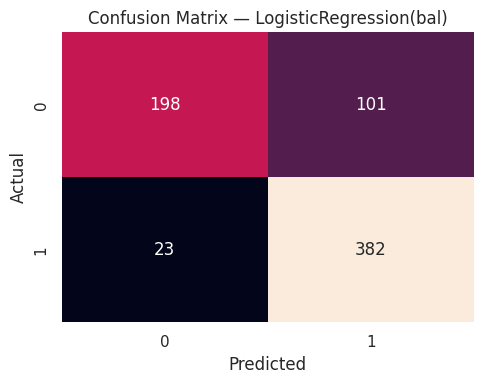

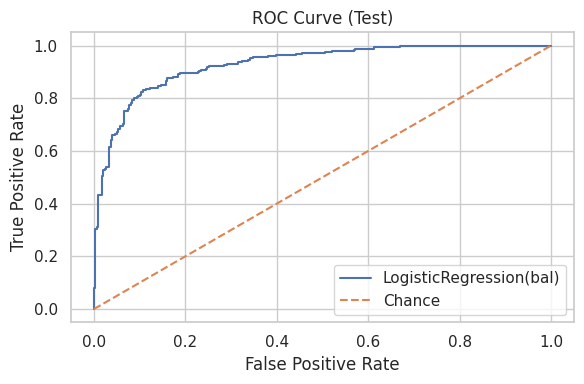

In [13]:
# Built surge/non-surge labels from training distribution (75th percentile)
y_raw_all = daily['pax']
threshold = y_raw_all.loc[X_train.index].quantile(0.75)
y_class_all = (y_raw_all >= threshold).astype(int)

y_class_train = y_class_all.loc[X_train.index]
y_class_test  = y_class_all.loc[X_test.index]

# Created a small chronological validation inside train (last 20% of train)
inner_split = int(len(X_train) * 0.8)
X_tr_in, X_val_in = X_train.iloc[:inner_split], X_train.iloc[inner_split:]
y_tr_in, y_val_in = y_class_train.iloc[:inner_split], y_class_train.iloc[inner_split:]

# Drop rows with NaN from the training data for classification
mask_tr_in = X_tr_in.notna().all(axis=1)
X_tr_in = X_tr_in.loc[mask_tr_in]
y_tr_in = y_tr_in.loc[mask_tr_in]

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)

def eval_cls(y_true, y_pred, y_proba):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC":   roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else np.nan
    }

candidates = {}

# Logistic Regression (balanced)
logit = LogisticRegression(max_iter=1000, class_weight='balanced')
logit.fit(X_tr_in, y_tr_in)
val_proba_log = logit.predict_proba(X_val_in)[:,1]
val_pred_log  = (val_proba_log >= 0.5).astype(int)
candidates["LogisticRegression(bal)"] = eval_cls(y_val_in, val_pred_log, val_proba_log)

# Decision Tree (tuned shallow depth for clarity)
best_depth, best_f1 = None, -1
for d in [2,3,4,5]:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42, class_weight='balanced')
    dt.fit(X_tr_in, y_tr_in)
    pred = dt.predict(X_val_in)
    f1 = f1_score(y_val_in, pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_depth = f1, d
tree_cls = DecisionTreeClassifier(max_depth=best_depth, random_state=42, class_weight='balanced')
tree_cls.fit(X_tr_in, y_tr_in)
val_proba_tree = tree_cls.predict_proba(X_val_in)[:,1]
val_pred_tree  = (val_proba_tree >= 0.5).astype(int)
candidates[f"DecisionTree(depth={best_depth})"] = eval_cls(y_val_in, val_pred_tree, val_proba_tree)

# Random Forest (balanced)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_tr_in, y_tr_in)
val_proba_rf = rf.predict_proba(X_val_in)[:,1]
val_pred_rf  = (val_proba_rf >= 0.5).astype(int)
candidates["RandomForest(200,bal)"] = eval_cls(y_val_in, val_pred_rf, val_proba_rf)

# Picked best by F1 on validation
best_name = max(candidates, key=lambda k: candidates[k]["F1"])
print("Validation scores:")
for k,v in candidates.items():
    print(k, v)
print("\nSelected:", best_name)

# Refit best on full training and evaluated on test
# Drop rows with NaN from the full training data for classification
mask_train = X_train.notna().all(axis=1)
X_train_cleaned = X_train.loc[mask_train]
y_class_train_cleaned = y_class_train.loc[mask_train]


if best_name.startswith("Logistic"):
    best = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_train_cleaned, y_class_train_cleaned)
elif best_name.startswith("DecisionTree"):
    best = DecisionTreeClassifier(max_depth=best_depth, random_state=42, class_weight='balanced').fit(X_train_cleaned, y_class_train_cleaned)
else:
    best = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced').fit(X_train_cleaned, y_class_train_cleaned)


# Drop rows with NaN from the test data for classification
mask_test = X_test.notna().all(axis=1)
X_test_cleaned = X_test.loc[mask_test]
y_class_test_cleaned = y_class_test.loc[mask_test]


test_proba = best.predict_proba(X_test_cleaned)[:,1]
test_pred  = (test_proba >= 0.5).astype(int)
test_scores = eval_cls(y_class_test_cleaned, test_pred, test_proba)

print("\nTest scores (", best_name, "):", sep="")
for k,v in test_scores.items():
    print(f"{k}: {v:.4f}")

# Plotted confusion matrix
cm = confusion_matrix(y_class_test_cleaned, test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()

# Plotted ROC curve
fpr, tpr, _ = roc_curve(y_class_test_cleaned, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=best_name)
plt.plot([0,1],[0,1],'--', label='Chance')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)"); plt.legend(); plt.tight_layout(); plt.show()

Linear Regression — intercept (log scale): 11.14956207893225 

Linear Regression — top positive coefficients:
rollmean_7              0.473175
lag_1                   0.226053
month_name_February     0.130135
month_name_January      0.099877
dow_name_Sunday         0.086785
dow_name_Thursday       0.079323
lag_7                   0.056882
month_name_December     0.056309
month_name_November     0.055796
dow                     0.050676
dow_name_Friday         0.044494
month_name_September    0.029494
dow_name_Monday         0.025077
month_name_October      0.010459
dow_name_Wednesday      0.003156
month                   0.001334
month_name_March       -0.000423
lag_14                 -0.007340
month_name_August      -0.023307
month_name_July        -0.032091
Name: coef_log, dtype: float64

Linear Regression — top negative coefficients:
rollmean_14            -0.154857
dow_name_Saturday      -0.125357
month_name_April       -0.123611
dow_name_Tuesday       -0.113477
month_name_May     

,pct_effect_%,abs_coef
rollmean_7,60.508152,0.473175
lag_1,25.364240,0.226053
rollmean_14,-14.346240,0.154857
month_name_February,13.898188,0.130135
dow_name_Saturday,-11.781790,0.125357
month_name_April,-11.627606,0.123611
dow_name_Tuesday,-10.727545,0.113477
month_name_May,-10.504962,0.110987
month_name_January,10.503468,0.099877
month_name_June,-8.757621,0.091651



Logistic Regression — intercept (log-odds): -0.6426815468192869 

Logistic Regression — top positive log-odds:
lag_1                   2.740912
rollmean_7              1.813135
dow_name_Sunday         1.270573
lag_7                   1.128035
lag_14                  0.895814
dow_name_Thursday       0.757921
month_name_February     0.671210
rollmean_14             0.597469
dow_name_Friday         0.545304
dow                     0.527086
dow_name_Monday         0.393315
month_name_November     0.329488
month_name_May          0.257419
month_name_June         0.251627
month_name_March        0.205485
month_name_December     0.205001
dom                     0.102329
dow_name_Wednesday     -0.045881
month_name_September   -0.120500
month                  -0.152596
Name: log_odds, dtype: float64

Logistic Regression — top negative log-odds:
dow_name_Saturday      -1.886886
dow_name_Tuesday       -1.329579
is_weekend             -0.616313
month_name_January     -0.558578
month_name_August  

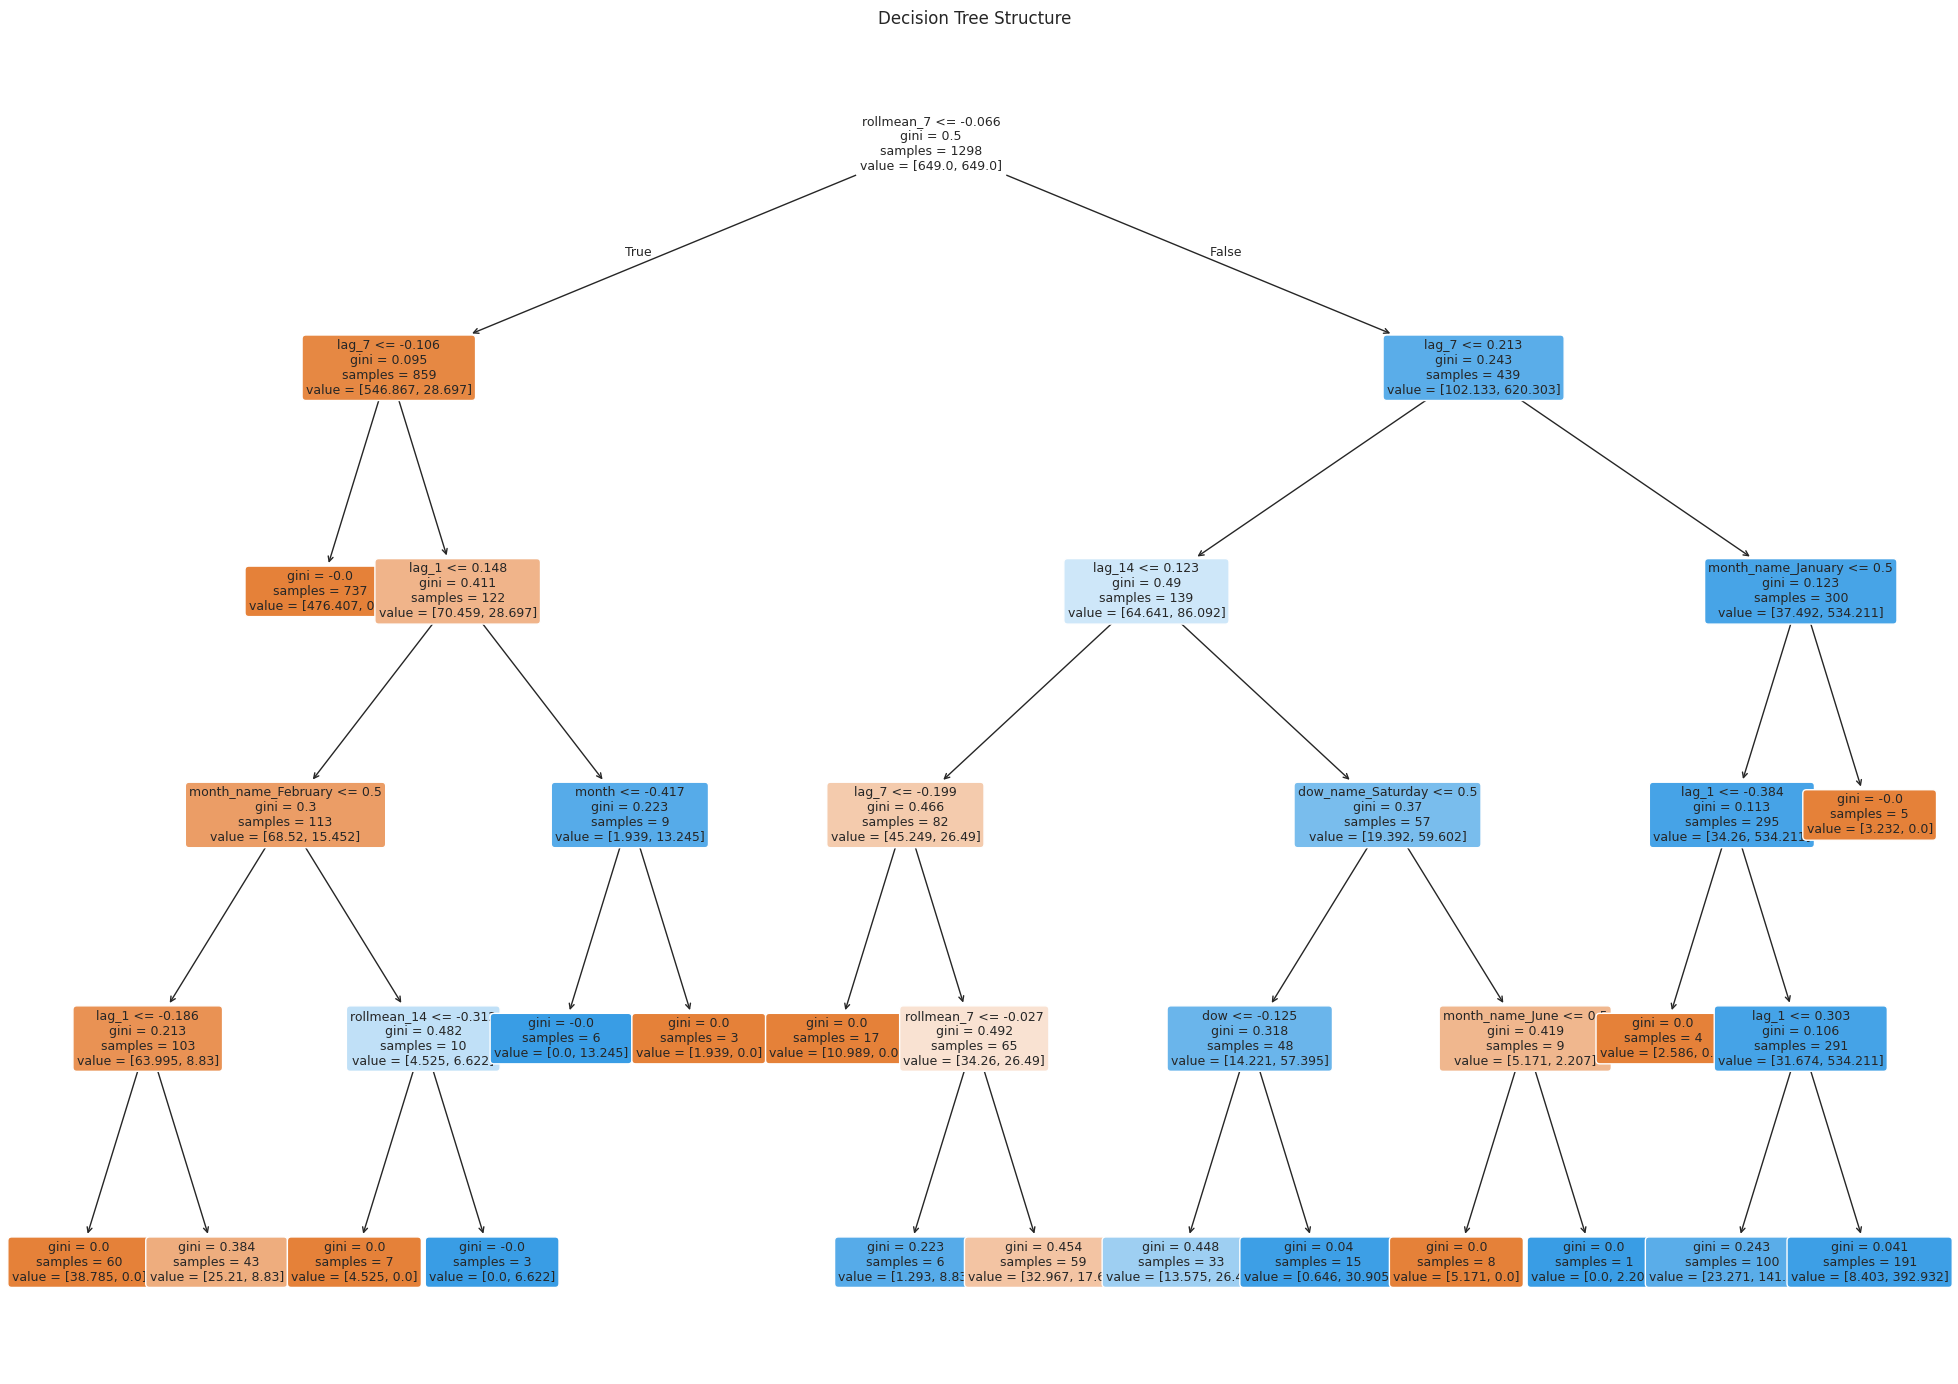

In [18]:
# ================================
# Coefficients & Model Introspection
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import plot_tree

# --- Linear Regression coefficients (target was log1p(pax)) ---
try:
    lin_model = lin_reg
except NameError:
    lin_model = LinearRegression().fit(X_train, y_reg_train)

lin_coef = pd.Series(lin_model.coef_, index=X_train.columns, name="coef_log")
print("Linear Regression — intercept (log scale):", lin_model.intercept_, "\n")

print("Linear Regression — top positive coefficients:")
print(lin_coef.sort_values(ascending=False).head(20))
print("\nLinear Regression — top negative coefficients:")
print(lin_coef.sort_values().head(20))

# (optional) percent effect on original scale: 100*(exp(coef)-1)
lin_effect = 100 * (np.exp(lin_coef) - 1)
lin_effect = lin_effect.to_frame("pct_effect_%").assign(abs_coef=lin_coef.abs()) \
                     .sort_values("abs_coef", ascending=False)
print("\nLinear Regression — top |coef| with percent effects:")
display(lin_effect.head(15))

# --- Logistic Regression log-odds (classification) ---
# picked an available logistic model (log_reg or logit or best_cls if it is LogisticRegression)
log_model = None
for cand in ["log_reg", "logit", "best_cls"]:
    if cand in globals():
        m = globals()[cand]
        if isinstance(m, LogisticRegression):
            log_model = m
            break

if log_model is not None:
    log_odds = log_model.coef_[0]  # shape (1, n_features) for binary
    log_odds_series = pd.Series(log_odds, index=X_train.columns, name="log_odds")
    print("\nLogistic Regression — intercept (log-odds):", log_model.intercept_[0], "\n")

    print("Logistic Regression — top positive log-odds:")
    print(log_odds_series.sort_values(ascending=False).head(20))
    print("\nLogistic Regression — top negative log-odds:")
    print(log_odds_series.sort_values().head(20))

    # (optional) odds ratios
    odds_ratio = np.exp(log_odds_series).rename("odds_ratio")
    print("\nLogistic Regression — top odds ratios:")
    print(odds_ratio.sort_values(ascending=False).head(15))
else:
    print("\n[Info] No fitted LogisticRegression model was found (expected one of: log_reg, logit, or best_cls).")

# --- Decision Tree structure (classification) ---
# picked an available tree classifier (dt_clf or tree_cls)
tree_model = None
for cand in ["dt_clf", "tree_cls"]:
    if cand in globals():
        tree_model = globals()[cand]
        break

if tree_model is not None:
    plt.figure(figsize=(20, 14))
    plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=9)
    plt.title("Decision Tree Structure")
    plt.tight_layout()
    plt.show()
else:
    print("\n[Info] No fitted Decision Tree classifier was found (expected dt_clf or tree_cls).")



## 5. Interpreting Results

- **Regression:** Compare MAE/RMSE/MAPE across Naïve, Linear Regression, and Decision Tree. Linear Regression offers transparency (coefficients), while a shallow Decision Tree gives human-readable rules (e.g., "if lag_7 > X then…").  
- **Classification:** Check **F1** and **ROC AUC** to ensure we capture surge days without too many false alarms. The confusion matrices help visualize tradeoffs.  
- **Feature effects:** Inspect Linear Regression coefficients and Decision Tree feature importances to understand which lags and rolling means matter most.  
- **Operational link:** Use forecasts to set checkpoint staffing for the next month; use surge-day classification to trigger staffing “surge plans.”


DT — best params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}
DT — best CV F1 : 0.5574
RF — best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 6}
RF — best CV F1 : 0.6407

Selected: Random Forest

Test metrics: {'Accuracy': 0.8253, 'Precision': 0.7913, 'Recall': 0.9457, 'F1': 0.8616, 'ROC_AUC': np.float64(0.9249)}


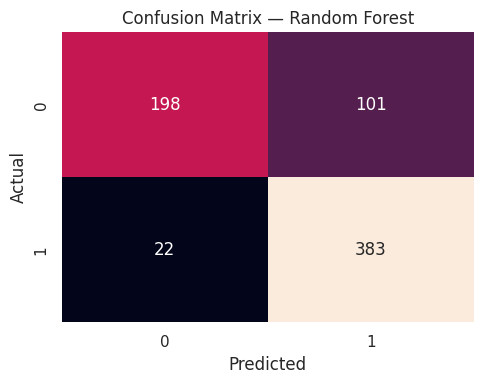


Top features:


,0
lag_7,0.229730
rollmean_7,0.191559
lag_14,0.187868
rollmean_14,0.167115
lag_1,0.111945
month,0.019403
dow_name_Saturday,0.014497
dom,0.011284
month_name_January,0.010906
dow,0.010353


In [21]:
# ================================
# Fast Hyperparameter Tuning (Classification)

# ================================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Used a small tuning window for speed
tune_window = 365
tune_idx = X_train.index[-tune_window:] if len(X_train) > tune_window else X_train.index
Xt, yt = X_train.loc[tune_idx], y_class_train.loc[tune_idx]

tscv = TimeSeriesSplit(n_splits=3)
N_ITER = 20  # kept small for speed

# --- Decision Tree (balanced) ---
dt_est = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
dt_rs = RandomizedSearchCV(
    estimator=dt_est,
    param_distributions=dt_space,
    n_iter=N_ITER,
    cv=tscv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    refit=True
)
dt_rs.fit(Xt, yt)

print("DT — best params:", dt_rs.best_params_)
print("DT — best CV F1 :", round(dt_rs.best_score_, 4))

# --- Random Forest (balanced) ---
rf_est = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_space = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 6, 10, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}
rf_rs = RandomizedSearchCV(
    estimator=rf_est,
    param_distributions=rf_space,
    n_iter=N_ITER,
    cv=tscv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    refit=True
)
rf_rs.fit(Xt, yt)

print("RF — best params:", rf_rs.best_params_)
print("RF — best CV F1 :", round(rf_rs.best_score_, 4))

# Picked winner by CV F1
winner = ('RF', rf_rs) if rf_rs.best_score_ >= dt_rs.best_score_ else ('DT', dt_rs)
print("\nSelected:", "Random Forest" if winner[0]=='RF' else "Decision Tree")

# Re-fitted winner on full training and evaluated on test
best_model = winner[1].best_estimator_.fit(X_train, y_class_train)
test_proba = best_model.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)

test_scores = {
    "Accuracy":  accuracy_score(y_class_test, test_pred),
    "Precision": precision_score(y_class_test, test_pred, zero_division=0),
    "Recall":    recall_score(y_class_test, test_pred, zero_division=0),
    "F1":        f1_score(y_class_test, test_pred, zero_division=0),
    "ROC_AUC":   roc_auc_score(y_class_test, test_proba) if len(np.unique(y_class_test))>1 else np.nan
}
print("\nTest metrics:", {k: round(v, 4) for k,v in test_scores.items()})

# Confusion matrix
cm = confusion_matrix(y_class_test, test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title(f"Confusion Matrix — {'Random Forest' if winner[0]=='RF' else 'Decision Tree'}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# (Optional) Feature importances
importances = getattr(best_model, "feature_importances_", None)
if importances is not None:
    imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(15)
    print("\nTop features:")
    display(imp)


In [2]:
%pip install ucimlrepo